# Notebook to benchmark gyoza against DiMSum

## Import libraries

In [1]:
import glob
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

## Specify paths

In [2]:
gyoza_rc_path = 'gyoza/annotated_readcounts/'
gyoza_avg_s_path = 'gyoza/avg_scores_CN__alp__F1.csv'

dimsum_rc_path = 'dimsum/CN_alp_F1_variant_data_merge.tsv'
dimsum_s_path = 'dimsum/fitness_singles.txt'

## Import read count data

### Import read count data from gyoza

In [3]:
list_df = []

for f in glob.glob(f"{gyoza_rc_path}/*"):
    list_df.append(pd.read_csv(f))

gyoza_rc = pd.concat(list_df, ignore_index=True)
gyoza_rc

,Mutated_seq,WT_seq,codon_mode,nt_seq,readcount,Sample_name,WT,aa_seq,Nham_codons,Nham_nt,Nham_aa,alt_aa,mutated_codon,mutation_alt_codons,mutation_alt_aa,mutation_type,mutation_aa_pos,aa_pos
0,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2337.0,CN_alp_r1_F1_T0,True,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0,0,0,"[""not-applicable""]",0,not-applicable,not-applicable,wt,not-applicable,"[""not-applicable""]"
1,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0,CN_alp_r1_F1_T0,False,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,3,1,"[""K""]",1,AAA,K,missense,2,[2]
2,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,3.0,CN_alp_r1_F1_T0,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,3,1,"[""P""]",1,CCT,P,missense,51,[51]
3,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,9.0,CN_alp_r1_F1_T0,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,2,0,"[""not-applicable""]",1,CGG,R,silent,51,"[""not-applicable""]"
4,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,3.0,CN_alp_r1_F1_T0,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,2,0,"[""not-applicable""]",1,CGT,R,silent,51,"[""not-applicable""]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11246,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,4.0,CN_alp_r1_F1_T1,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,2,1,"[""L""]",1,CTC,L,missense,50,[50]
11247,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,6.0,CN_alp_r1_F1_T1,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,3,1,"[""L""]",1,CTG,L,missense,50,[50]
11248,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,8.0,CN_alp_r1_F1_T1,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,3,1,"[""L""]",1,CTT,L,missense,50,[50]
11249,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0,CN_alp_r1_F1_T1,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,3,1,"[""E""]",1,GAA,E,missense,50,[50]


### Import read count data from DiMSum

In [4]:
dimsum_rc = pd.read_csv(dimsum_rc_path, sep='\t', dtype={'WT':'boolean'})
dimsum_rc['WT'] = dimsum_rc['WT'].fillna(False)
dimsum_rc

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1_e1_s0_bNA_count,input2_e2_s0_bNA_count,output1_e1_s1_b1_count,output2_e1_s1_b2_count,output1copy_e2_s1_b1_count,output2copy_e2_s1_b2_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaacctgttagcggttctccagctaagccagaagattacccacact...,KPVSGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,8,3,3,1,0,0,0,0,0,True,False,True,True,False,False
1,aaacctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,1,1,1,1,1,0,1,0,True,False,True,True,False,False
2,aaacctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,6,2,2,0,1,0,0,0,0,True,False,True,True,False,False
3,aaccctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEKGIPIGAALSHLPTSR...,False,False,False,8,3,3,0,1,0,0,0,0,True,False,True,True,False,False
4,aaccctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,1,1,0,2,0,3,0,3,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9362,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGSALV*LPTSR...,False,True,False,4,3,3,0,0,1,0,1,0,True,False,True,True,False,False
9363,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALPSLSEGGIPIGAALVHLPTSR...,False,False,False,4,2,2,0,0,0,1,0,1,True,False,True,True,False,False
9364,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAREQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,2,2,0,1,0,0,0,0,True,False,True,True,False,False
9365,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAVEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,2,2,1,0,0,0,0,0,True,False,True,True,False,False


### Remove duplicate columns due to exp design file redundancy

In [5]:
# Extract sample names, based on naming pattern in experimental design file (input/output)
input_conditions = [x for x in dimsum_rc.columns if 'input' in x]
output_conditions = [x for x in dimsum_rc.columns if ('output' in x) & ('_e1_' in x)]
duplicated_output = [x for x in dimsum_rc.columns if ('output' in x) & ('_e1_' not in x)]
input_samples = [x.split('_')[0] for x in input_conditions]
output_samples = [x.split('_')[-2] for x in output_conditions]
conditions = input_samples+output_samples
dimsum_rc.drop(columns=duplicated_output, inplace=True)
dimsum_rc.rename(columns=lambda x: x.split('_')[0] if 'input' in x else x, inplace=True)
dimsum_rc.rename(columns=lambda x: x.split('_')[-2] if 'output' in x else x, inplace=True)
len(dimsum_rc)

9367

### Discard singletons (no matter if the variant was sequenced before or after screening)

In [6]:
dimsum_no_singletons = dimsum_rc[(dimsum_rc[conditions] > 1).any(axis=1)]
dimsum_no_singletons

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,input2,b1,b2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
4,aaccctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,1,1,0,2,0,3,True,False,True,True,False,False
6,aagcctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQDLKSLSEGGIPIGAALVHLPTSR...,False,False,False,4,2,2,1,2,2,6,True,False,True,True,False,False
7,aagcctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,1,1,1,0,1,3,True,False,True,True,False,False
10,aatcctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,2,1,0,2,True,False,True,True,False,False
11,aatcctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHDQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,2,2,1,3,0,0,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9344,ttacctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,2,6,2,0,True,False,True,True,False,False
9347,ttccctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,3,6,0,0,True,False,True,True,False,False
9349,ttgcctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,4,0,0,0,True,False,True,True,False,False
9356,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,1,1,1,2,3,0,0,True,False,True,True,False,False


### Restrict to mutants with a single mutated codon (what we expect for this exp design)

In [7]:
dimsum_Ncod01 = dimsum_no_singletons[dimsum_no_singletons.Nmut_codons <= 1]
dimsum_Ncod01

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,input2,b1,b2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
4,aaccctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,1,1,0,2,0,3,True,False,True,True,False,False
7,aagcctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,1,1,1,0,1,3,True,False,True,True,False,False
10,aatcctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,2,1,0,2,True,False,True,True,False,False
14,acacctgttgaaggttctccagctaagccagaagattacccacact...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,4,3,0,0,True,False,True,True,False,False
18,acccctgttgaaggttctccagctaagccagaagattacccacact...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,3,3,1,1,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9342,tgtcctgttgaaggttctccagctaagccagaagattacccacact...,CPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,1,1,1,4,5,1,0,True,False,True,True,False,False
9344,ttacctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,2,6,2,0,True,False,True,True,False,False
9347,ttccctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,3,6,0,0,True,False,True,True,False,False
9349,ttgcctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1,4,0,0,0,True,False,True,True,False,False


## Quick comparisons

In [8]:
gyoza_unique = gyoza_rc.drop_duplicates(subset='nt_seq').copy()
gyoza_unique['nt_seq'] = gyoza_unique['nt_seq'].str.lower()
gyoza_unique

,Mutated_seq,WT_seq,codon_mode,nt_seq,readcount,Sample_name,WT,aa_seq,Nham_codons,Nham_nt,Nham_aa,alt_aa,mutated_codon,mutation_alt_codons,mutation_alt_aa,mutation_type,mutation_aa_pos,aa_pos
0,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,tctcctgttgaaggttctccagctaagccagaagattacccacact...,2337.0,CN_alp_r1_F1_T0,True,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0,0,0,"[""not-applicable""]",0,not-applicable,not-applicable,wt,not-applicable,"[""not-applicable""]"
1,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,aaacctgttgaaggttctccagctaagccagaagattacccacact...,2.0,CN_alp_r1_F1_T0,False,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,3,1,"[""K""]",1,AAA,K,missense,2,[2]
2,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,tctcctgttgaaggttctccagctaagccagaagattacccacact...,3.0,CN_alp_r1_F1_T0,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,3,1,"[""P""]",1,CCT,P,missense,51,[51]
3,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,tctcctgttgaaggttctccagctaagccagaagattacccacact...,9.0,CN_alp_r1_F1_T0,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,2,0,"[""not-applicable""]",1,CGG,R,silent,51,"[""not-applicable""]"
4,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,tctcctgttgaaggttctccagctaagccagaagattacccacact...,3.0,CN_alp_r1_F1_T0,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,2,0,"[""not-applicable""]",1,CGT,R,silent,51,"[""not-applicable""]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10895,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,tctcctgttgaaggttctccagctaagccagaagattacccacact...,4.0,CN_alp_r1_F1_T1,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,2,1,"[""N""]",1,AAC,N,missense,67,[67]
10898,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,tctcctgttgaaggttctccagctaagccagaagattacccacact...,2.0,CN_alp_r1_F1_T1,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1,3,1,"[""T""]",1,ACC,T,missense,67,[67]
11002,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,tctcctgttgaaggttctccagctaagccagaagattacccacact...,4.0,CN_alp_r1_F1_T1,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTLR...,1,3,1,"[""L""]",1,CTA,L,missense,46,[46]
11004,CN_F1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NNN,tctcctgttgaaggttctccagctaagccagaagattacccacact...,2.0,CN_alp_r1_F1_T1,False,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTLR...,1,3,1,"[""L""]",1,CTG,L,missense,46,[46]


In [9]:
merge_unique = pd.merge(left=dimsum_Ncod01, right=gyoza_unique, on=['nt_seq','aa_seq','WT','Nham_nt','Nham_aa'], how='outer', indicator='Location')
merge_unique

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,input2,...,Sample_name,Nham_codons,alt_aa,mutated_codon,mutation_alt_codons,mutation_alt_aa,mutation_type,mutation_aa_pos,aa_pos,Location
0,aaacctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,NaN,NaN,3,1,NaN,NaN,NaN,...,CN_alp_r1_F1_T0,1.0,"[""K""]",1.0,AAA,K,missense,2,[2],right_only
1,aaccctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,1,1.0,0.0,2.0,...,CN_alp_r2_F1_T1,1.0,"[""N""]",1.0,AAC,N,missense,2,[2],both
2,aagcctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,3,1,1.0,1.0,0.0,...,CN_alp_r2_F1_T1,1.0,"[""K""]",1.0,AAG,K,missense,2,[2],both
3,aatcctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1.0,2.0,1.0,...,CN_alp_r1_F1_T0,1.0,"[""N""]",1.0,AAT,N,missense,2,[2],both
4,acacctgttgaaggttctccagctaagccagaagattacccacact...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1.0,4.0,3.0,...,CN_alp_r1_F1_T0,1.0,"[""T""]",1.0,ACA,T,missense,2,[2],both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862,tgtcctgttgaaggttctccagctaagccagaagattacccacact...,CPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,1,1,1.0,4.0,5.0,...,CN_alp_r1_F1_T0,1.0,"[""C""]",1.0,TGT,C,missense,2,[2],both
3863,ttacctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1.0,2.0,6.0,...,CN_alp_r1_F1_T0,1.0,"[""L""]",1.0,TTA,L,missense,2,[2],both
3864,ttccctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1.0,3.0,6.0,...,CN_alp_r1_F1_T0,1.0,"[""F""]",1.0,TTC,F,missense,2,[2],both
3865,ttgcctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,False,False,False,2,1,1.0,4.0,0.0,...,CN_alp_r1_F1_T0,1.0,"[""L""]",1.0,TTG,L,missense,2,[2],both


In [10]:
dimsum_singletons = merge_unique.loc[merge_unique.Location == 'right_only']
print(f'{len(dimsum_singletons)} unique variants picked up by gyoza and DiMSum but singletons according to DiMSum')

17 unique variants picked up by gyoza and DiMSum but singletons according to DiMSum


In [11]:
len(merge_unique.loc[merge_unique.Location == 'both'])

3849

In [12]:
not_in_gyoza = merge_unique.loc[merge_unique.Location == 'left_only']
len(not_in_gyoza)

1

In summary, important overlap, only 1 variant not picked up by gyoza, but likely considered a singleton (only 2 reads in 1 replicate of input according to DiMSum). 17 variants picked up by gyoza discarded as singletons by DiMSum: all sequenced twice

## Apply read count filter

In [13]:
len(dimsum_Ncod01[(dimsum_Ncod01[input_samples] >=10).all(axis=1)].aa_seq.unique())

224

## Import fitness data

### Import fitness scores from gyoza

In [21]:
gyoza_s = pd.read_csv(gyoza_avg_s_path)
gyoza_s

,Nham_aa,aa_seq,aa_pos,alt_aa,fitness_T1,lower_err_T1,upper_err_T1,fitness_T2,lower_err_T2,upper_err_T2
0,0,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,not-applicable,not-applicable,-0.004177,0.035847,0.035847,0.020805,0.019765,0.019765
1,1,GPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2,G,0.994439,0.145851,0.145851,-0.721491,0.176982,0.176982
2,1,S*VEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3,*,2.454832,0.333341,0.333341,3.282440,0.168142,0.168142
3,1,SFVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3,F,-0.026905,0.464840,0.464840,-1.458460,0.120178,0.120178
4,1,SIVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3,I,0.341578,0.114782,0.114782,-0.532238,0.299971,0.299971
...,...,...,...,...,...,...,...,...,...,...
236,1,SPVEVSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,6,V,0.246372,0.100605,0.100605,-1.317726,0.100959,0.100959
237,1,SPVQGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,5,Q,0.267717,0.544536,0.544536,0.393367,0.173503,0.173503
238,1,SPWEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,4,W,-0.149115,0.776462,0.776462,-1.580669,0.421007,0.421007
239,1,SRVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3,R,-0.117191,0.182940,0.182940,-0.665978,0.676907,0.676907


### Remove WT

In [23]:
gyoza_s = gyoza_s.loc[gyoza_s.Nham_aa > 0]
gyoza_s.loc[:,'aa_pos'] = gyoza_s['aa_pos'].astype(int)
gyoza_s

,Nham_aa,aa_seq,aa_pos,alt_aa,fitness_T1,lower_err_T1,upper_err_T1,fitness_T2,lower_err_T2,upper_err_T2
1,1,GPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2,G,0.994439,0.145851,0.145851,-0.721491,0.176982,0.176982
2,1,S*VEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3,*,2.454832,0.333341,0.333341,3.282440,0.168142,0.168142
3,1,SFVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3,F,-0.026905,0.464840,0.464840,-1.458460,0.120178,0.120178
4,1,SIVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3,I,0.341578,0.114782,0.114782,-0.532238,0.299971,0.299971
5,1,SPREGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,4,R,-0.630131,0.141659,0.141659,-0.108240,0.147055,0.147055
...,...,...,...,...,...,...,...,...,...,...
236,1,SPVEVSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,6,V,0.246372,0.100605,0.100605,-1.317726,0.100959,0.100959
237,1,SPVQGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,5,Q,0.267717,0.544536,0.544536,0.393367,0.173503,0.173503
238,1,SPWEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,4,W,-0.149115,0.776462,0.776462,-1.580669,0.421007,0.421007
239,1,SRVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3,R,-0.117191,0.182940,0.182940,-0.665978,0.676907,0.676907


### Import fitness data from DiMSum

In [24]:
dimsum_s = pd.read_csv(dimsum_s_path, sep=' ')
dimsum_s

,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma
0,1,S,G,NaN,GPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,12.0,0.060966,0.322229
1,1,S,V,NaN,VPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,14.0,-0.781120,0.400107
2,2,P,I,NaN,SIVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,14.0,-0.375158,0.344918
3,3,V,R,NaN,SPREGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,12.5,-2.042810,0.733356
4,4,E,Q,NaN,SPVQGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,12.0,-0.913248,0.455539
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,5,G,F,NaN,SPVEFSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,18.0,-0.779218,0.360199
217,2,P,R,NaN,SRVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,13.0,-0.485487,0.371447
218,2,P,*,NaN,S*VEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,True,False,17.5,1.853890,0.188435
219,2,P,L,NaN,SLVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,10.5,-0.781898,0.461865


### Offset position in protein sequence

In [25]:
dimsum_s['Pos'] += 1

### Merge fitness data

In [26]:
fitness_merge = pd.merge(left=dimsum_s[['Pos','Mut','aa_seq','fitness','sigma']].rename(columns={'fitness':'fitness_dimsum', 'sigma':'sigma_dimsum'}),
                         right=gyoza_s[['aa_pos','alt_aa','fitness_T1','lower_err_T1','upper_err_T1']].rename(columns={'aa_pos':'Pos', 'alt_aa':'Mut'}))
fitness_merge

,Pos,Mut,aa_seq,fitness_dimsum,sigma_dimsum,fitness_T1,lower_err_T1,upper_err_T1
0,2,G,GPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.060966,0.322229,0.994439,0.145851,0.145851
1,2,V,VPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.781120,0.400107,-0.597141,0.694008,0.694008
2,3,I,SIVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.375158,0.344918,0.341578,0.114782,0.114782
3,4,R,SPREGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-2.042810,0.733356,-0.630131,0.141659,0.141659
4,5,Q,SPVQGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.913248,0.455539,0.267717,0.544536,0.544536
...,...,...,...,...,...,...,...,...
212,6,C,SPVECSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.876177,0.396481,-0.455229,0.288510,0.288510
213,6,F,SPVEFSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.779218,0.360199,-0.573864,0.267314,0.267314
214,3,R,SRVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.485487,0.371447,-0.117191,0.182940,0.182940
215,3,*,S*VEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.853890,0.188435,2.454832,0.333341,0.333341


In [27]:
len(fitness_merge.aa_seq.unique())

217

## Plot correlation

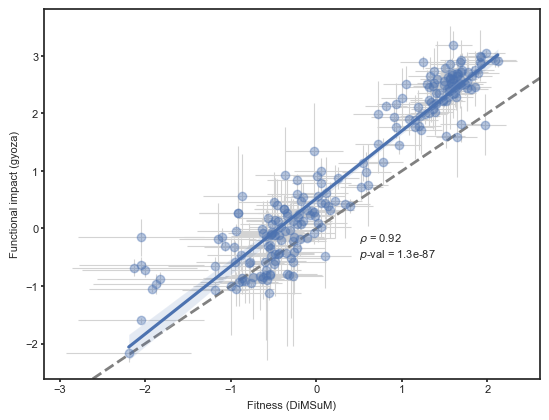

In [28]:
sns.set(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

g = sns.regplot(data=fitness_merge, x='fitness_dimsum', y='fitness_T1', scatter_kws={'alpha':.4})
plt.axline((1,1), slope=1, ls='--', lw=2, color='.5', zorder=-10)

g.errorbar(x=fitness_merge.fitness_dimsum,y=fitness_merge.fitness_T1,
           xerr=fitness_merge.sigma_dimsum,yerr=[fitness_merge.lower_err_T1, fitness_merge.upper_err_T1],
           elinewidth=.8, fmt='none', ecolor='lightgrey',zorder=-1000
          )

# Calculate and display Spearman correlation coefficient
sr, sp = stats.spearmanr(fitness_merge.fitness_dimsum, fitness_merge.fitness_T1)
g.text(.5, -0.5, fr'$\rho$ = {sr:.2f}'+
       '\n$\it{p}$-val = '+f'{sp:.1e}', ha='left')

g.set(xlabel='Fitness (DiMSuM)', ylabel='Functional impact (gyoza)')
plt.savefig('DiMSum_corr.svg', format='svg', dpi=300)
plt.savefig('DiMSum_corr.png', format='png', dpi=300)